In [1]:
import anndata as ad
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import scvi
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold, train_test_split

/home/albert.baichorov/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/albert.baichorov/.venv/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/albert.baichorov/.venv/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [31]:
def evaluate_cell_types(
    cell_embeddings: pd.DataFrame,
    train_model_fn,
    drop_columns: list = ['sampleName', 'secondary_type'],
    verbose: bool = True
):
    results = []
    cell_types = cell_embeddings['secondary_type'].unique()
    
    for cell_type in cell_types:
        if verbose:
            print(f"Evaluating: {cell_type}")
            
        filtered_data = cell_embeddings[cell_embeddings['secondary_type'] == cell_type] \
            .drop(columns=drop_columns)
        
        test_score = train_model_fn(filtered_data)
        
        if verbose:
            print(f"test_score: {test_score}")
            
        results.append([cell_type, test_score])
    
    return pd.DataFrame(results, columns=['cell_type', 'test r2'])

def train_model(filtered_data):

    stratify_bins = pd.qcut(filtered_data['age'], q=10, duplicates='drop')

    X_train, X_test, y_train, y_test = train_test_split(
        filtered_data.drop(columns=['age']),
        filtered_data['age'],
        test_size=0.3,
        random_state=42,
        stratify=stratify_bins
    )

    model = RandomForestRegressor(n_estimators=500, max_features=0.4, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return r2_score(y_test, y_pred)


# def build_sample_level_dataset(cell_embeddings: pd.DataFrame) -> pd.DataFrame:
#     # Удалим всё кроме нужного
#     df = cell_embeddings.drop(columns=['age'])  # age потом можно будет восстановить

#     # Группируем: для каждого sample и типа клетки — усредняем эмбеддинги
#     grouped = df.groupby(['sampleName', 'secondary_type']).mean(numeric_only=True)

#     # Делаем pivot, чтобы:
#     # - sampleName = строки
#     # - (secondary_type, embedding_dim) = столбцы
#     flat = grouped.unstack('secondary_type')

#     # Приводим MultiIndex в колонках к обычному виду: "CD4_TEM_XXX_12"
#     flat.columns = [f"{ctype}_{dim}" for dim, ctype in flat.columns]

#     # Сбросим индекс (sampleName станет обычным столбцом)
#     flat = flat.reset_index()

    

#     return flat

def build_sample_level_dataset(cell_embeddings: pd.DataFrame) -> pd.DataFrame:
    # Удалим всё кроме нужного
    df = cell_embeddings.drop(columns=['age'])

    # Группируем: усредняем эмбеддинги по sample и типу клетки
    grouped = df.groupby(['sampleName', 'secondary_type']).mean(numeric_only=True)

    # Pivot: строки = sampleName, колонки = (embedding_dim, cell_type)
    flat = grouped.unstack('secondary_type')

    # Переименовываем MultiIndex в колонках → "celltype_dim"
    flat.columns = [f"{ctype}_{dim}" for dim, ctype in flat.columns]

    # Сбросим индекс: sampleName → колонка
    flat = flat.reset_index()

    # Добавляем age по sampleName (берём первое значение для каждого sample)
    age_df = cell_embeddings.groupby('sampleName')['age'].first().reset_index()

    # Слияние
    flat = flat.merge(age_df, on='sampleName')
    flat.drop(columns=['sampleName'], inplace=True)

    return flat



def draw_results(report):
    report_sorted = report.sort_values(by='test r2', ascending=True)

    fig, ax = plt.subplots(figsize=(6, 6))

    colors = plt.cm.Blues((report_sorted['test r2'] - report_sorted['test r2'].min()) /
                        (report_sorted['test r2'].max() - report_sorted['test r2'].min()))

    ax.scatter(report_sorted['test r2'], report_sorted['cell_type'],
            c=colors, s=100)

    ax.set_xlabel('Variance explained on test (%)')
    ax.set_ylabel('Cell Type')
    ax.axvline(x=0, color='gray', linestyle='--')
    ax.grid(True, axis='x', linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

# PCA emb 

In [20]:
cell_embeddings = pd.read_csv('/home/albert.baichorov/ImSysAging/data/scRNA-seqEmbAge.csv', index_col=0)
cell_embeddings = cell_embeddings.drop(columns=['primary_type']).groupby(['sampleName','secondary_type','age']).mean().reset_index()

In [27]:
cell_embeddings['age'] 

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1489    2.0
1490    2.0
1491    2.0
1492    2.0
1493    2.0
Name: age, Length: 1494, dtype: float64

In [32]:
sample_level_df = build_sample_level_dataset(cell_embeddings)
sample_level_df

,B_Atypical_Memory_0,B_BCR_GNLY_0,B_Memory_0,B_Naive_0,CD4_Naive_CCR7_0,CD4_TCM_AQP3_0,CD4_TEM_ANXA1_0,CD4_TEM_GNLY_0,CD4_Treg_FOXP3_0,CD8_MAIT_SLC4A10_0,...,Monocytes_CD14_49,Monocytes_CD16_49,NK_CD56_Bright_49,NK_CD56_Dim_49,NK_Proliferating_49,Plasma cell_49,gdT_49,mDC_49,pDC_49,age
0,2.863225,-3.045168,0.484324,-0.473349,-9.605708,-9.319408,-8.204167,-9.263766,-4.821432,-6.581191,...,0.034023,-0.144203,0.665304,-0.039454,0.545736,NaN,0.301225,-0.739624,-0.077341,0.0
1,2.107654,-1.352316,0.469393,-1.001113,-9.959259,-8.513213,-7.337423,-8.373496,-6.460500,-7.792347,...,0.050205,-0.129106,1.092850,-0.103090,-0.982208,-0.411174,0.336661,-1.466534,0.012330,2.0
2,2.424367,-3.124134,0.008914,-1.065802,-9.969420,-8.508588,-7.129406,-8.092829,-6.161164,-7.850800,...,-0.004426,0.005340,0.768137,-0.105485,-0.370738,-0.124869,0.542938,-1.810402,0.019213,2.0
3,3.342326,4.691088,0.635582,-0.770627,-10.192537,-8.456673,-7.192668,-7.184922,-6.455811,-8.007447,...,0.188857,-0.367778,1.026257,-0.154719,-0.689990,-0.424964,0.242087,-3.218537,0.316121,2.0
4,4.448154,-1.504039,0.065365,-0.864247,-10.813661,-8.692740,-7.586949,-7.254130,-6.291441,-8.072742,...,0.007408,-0.266955,1.104297,-0.139348,-0.246716,-0.217667,-0.056207,-0.332022,0.150040,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2.357225,-5.622366,-0.194656,-1.038253,-10.049587,-9.486790,-8.249943,-6.050395,-6.565026,-7.215814,...,-0.096033,0.669227,1.071149,-0.074820,-1.849163,NaN,0.025606,NaN,NaN,29.0
57,2.386480,-2.023276,-0.189389,-1.209405,-10.174140,-9.132451,-7.734277,-5.681832,-6.147682,-7.728710,...,-0.051415,-0.408333,0.679340,-0.795587,-0.346475,-0.205546,-0.068751,-3.442144,0.209548,29.0
58,1.540806,-2.359972,0.542740,-1.012626,-9.978087,-8.480647,-6.864601,-8.867090,-6.012112,-7.536988,...,0.050454,-0.067367,0.833598,-0.092553,-0.009932,-0.032821,0.293548,-2.344070,0.014815,1.0
59,2.111025,1.657695,-0.099591,-1.415025,-10.031315,-8.355589,-6.986074,-8.682545,-5.740434,-7.922957,...,-0.014566,-0.037409,0.631794,-0.081439,0.702237,-0.466153,0.314946,-1.114726,0.013328,1.0


Evaluating: B_Atypical_Memory
test_score: -0.08217028149726802
Evaluating: B_BCR_GNLY
test_score: 0.1363851923884215
Evaluating: B_Memory
test_score: 0.09420579770244575
Evaluating: B_Naive
test_score: -0.1644017841367844
Evaluating: CD4_Naive_CCR7
test_score: 0.7343624136456043
Evaluating: CD4_TCM_AQP3
test_score: 0.6032833028619796
Evaluating: CD4_TEM_ANXA1
test_score: 0.5754726007663183
Evaluating: CD4_TEM_GNLY
test_score: -0.1934474418051373
Evaluating: CD4_Treg_FOXP3
test_score: 0.4651971906348955
Evaluating: CD8_MAIT_SLC4A10
test_score: 0.2871560239682309
Evaluating: CD8_Naive_LEF1
test_score: 0.5601662472321098
Evaluating: CD8_TCM_HAVCR2
test_score: 0.43133998931007334
Evaluating: CD8_TEM_CMC1
test_score: 0.28063504287301344
Evaluating: CD8_TEM_GNLY
test_score: 0.4729818838279639
Evaluating: CD8_TEM_ZNF683
test_score: 0.5630633122254758
Evaluating: Mega
test_score: 0.15391002143272792
Evaluating: Monocytes_CD14
test_score: 0.05628543566025046
Evaluating: Monocytes_CD16
test_scor

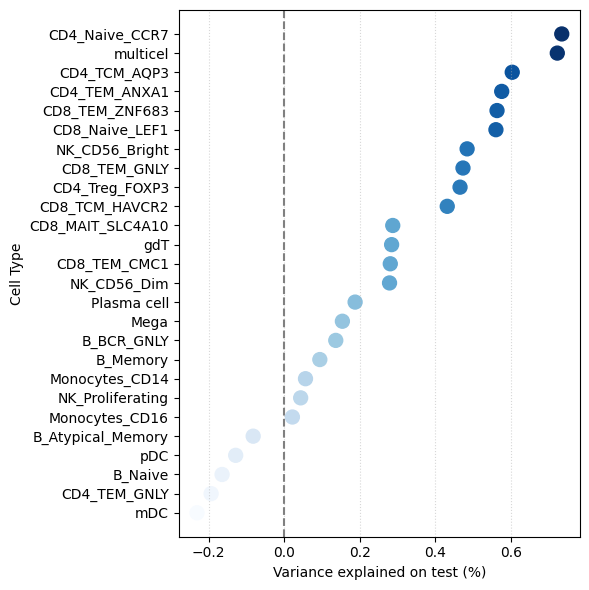

In [35]:
report = evaluate_cell_types(cell_embeddings, train_model)
multicel = train_model(sample_level_df)
new_row = pd.DataFrame([['multicel', multicel]], columns=report.columns)
report = pd.concat([report, new_row], ignore_index=True)

draw_results(report)

# MRVI embedings, no specified batch

In [36]:
adata = ad.read_h5ad("/home/albert.baichorov/ImSysAging/data/scRNA-seq_MRVI_no_batch.h5ad")

## Lets start with context-free embedings U

/tmp/ipykernel_1830255/722922595.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = data.drop(columns='primary_type').groupby(['sampleName','secondary_type','age']).mean().reset_index()


Evaluating: B_Atypical_Memory
test_score: 0.18891222087197057
Evaluating: B_BCR_GNLY
test_score: 0.3327518651621405
Evaluating: B_Memory
test_score: 0.21386711383875556
Evaluating: B_Naive
test_score: 0.1680063467109949
Evaluating: CD4_Naive_CCR7
test_score: 0.2177278884379652
Evaluating: CD4_TCM_AQP3
test_score: 0.004788414960588239
Evaluating: CD4_TEM_ANXA1
test_score: 0.3184424048337
Evaluating: CD4_TEM_GNLY
test_score: 0.2746526460726366
Evaluating: CD4_Treg_FOXP3
test_score: -0.3416953644848508
Evaluating: CD8_MAIT_SLC4A10
test_score: 0.18364244192341117
Evaluating: CD8_Naive_LEF1
test_score: 0.0292533689890494
Evaluating: CD8_TCM_HAVCR2
test_score: 0.15800104774396628
Evaluating: CD8_TEM_CMC1
test_score: 0.405362471504901
Evaluating: CD8_TEM_GNLY
test_score: 0.1903121975498977
Evaluating: CD8_TEM_ZNF683
test_score: 0.5633170581991216
Evaluating: Mega
test_score: 0.11620058426100188
Evaluating: Monocytes_CD14
test_score: -0.009221142947831273
Evaluating: Monocytes_CD16
test_score:

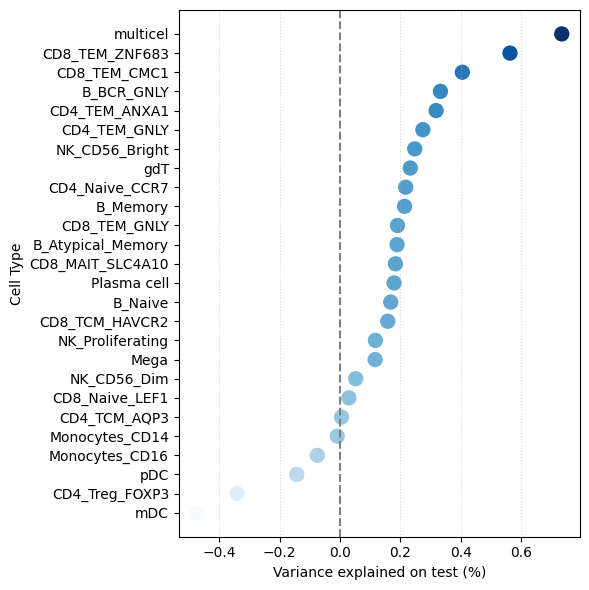

In [37]:
data = pd.concat([adata.obs[['sampleName','primary_type','secondary_type','age']].reset_index(drop=True),
                  pd.DataFrame(adata.obsm['U_mrvi']).reset_index(drop=True)], axis=1)
data = data.drop(columns='primary_type').groupby(['sampleName','secondary_type','age']).mean().reset_index()
data = data.dropna()
data.sampleName = data.sampleName.astype('str')
data.secondary_type = data.secondary_type.astype('str')
data.age = data.age.astype('float')

report = evaluate_cell_types(data, train_model)


sample_level_df = build_sample_level_dataset(cell_embeddings)
multicel = train_model(sample_level_df)
new_row = pd.DataFrame([['multicel', multicel]], columns=report.columns)
report = pd.concat([report, new_row], ignore_index=True)

draw_results(report)

# Z embedings

/tmp/ipykernel_1830255/2711258425.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = data.drop(columns='primary_type').groupby(['sampleName','secondary_type','age']).mean().reset_index()


Evaluating: B_Atypical_Memory
test_score: 0.48539023199643294
Evaluating: B_BCR_GNLY
test_score: 0.3796399079060837
Evaluating: B_Memory
test_score: 0.5542491522500593
Evaluating: B_Naive
test_score: 0.27180660736760853
Evaluating: CD4_Naive_CCR7
test_score: 0.7055966637797477
Evaluating: CD4_TCM_AQP3
test_score: 0.6254083188911813
Evaluating: CD4_TEM_ANXA1
test_score: 0.44409987040605803
Evaluating: CD4_TEM_GNLY
test_score: 0.5288334360804431
Evaluating: CD4_Treg_FOXP3
test_score: 0.5617075112189297
Evaluating: CD8_MAIT_SLC4A10
test_score: 0.4032393211254427
Evaluating: CD8_Naive_LEF1
test_score: 0.7216736834818358
Evaluating: CD8_TCM_HAVCR2
test_score: 0.5661201099488457
Evaluating: CD8_TEM_CMC1
test_score: 0.4970336354924768
Evaluating: CD8_TEM_GNLY
test_score: 0.4182441983963241
Evaluating: CD8_TEM_ZNF683
test_score: 0.6482774268601093
Evaluating: Mega
test_score: 0.2807253726014769
Evaluating: Monocytes_CD14
test_score: 0.30944982362587947
Evaluating: Monocytes_CD16
test_score: 0.

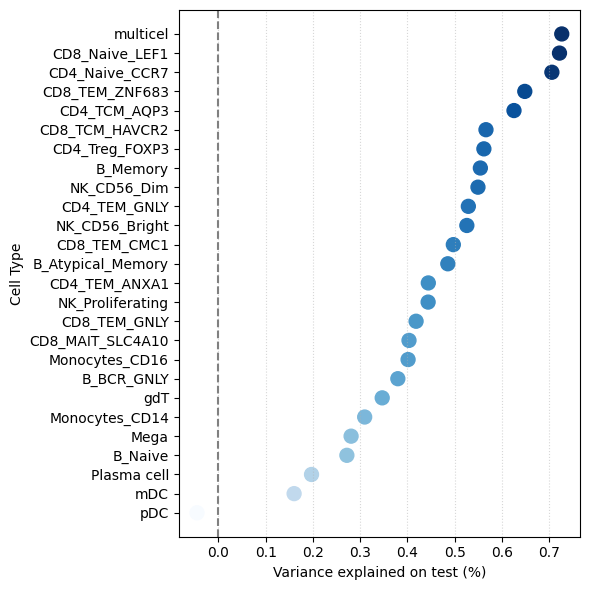

In [38]:
data = pd.concat([adata.obs[['sampleName','primary_type','secondary_type','age']].reset_index(drop=True),
                  pd.DataFrame(adata.obsm['Z_mrvi']).reset_index(drop=True)], axis=1)
data = data.drop(columns='primary_type').groupby(['sampleName','secondary_type','age']).mean().reset_index()
data = data.dropna()
data.sampleName = data.sampleName.astype('str')
data.secondary_type = data.secondary_type.astype('str')
data.age = data.age.astype('float')

report = evaluate_cell_types(data, train_model)


sample_level_df = build_sample_level_dataset(cell_embeddings)
multicel = train_model(sample_level_df)
new_row = pd.DataFrame([['multicel', multicel]], columns=report.columns)
report = pd.concat([report, new_row], ignore_index=True)

draw_results(report)

# MRVI embedings, sample batch

In [39]:
adata = ad.read_h5ad("/home/albert.baichorov/ImSysAging/data/scRNA-seq_MRVI_sample_batch.h5ad")

# U embedings

/tmp/ipykernel_1830255/722922595.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = data.drop(columns='primary_type').groupby(['sampleName','secondary_type','age']).mean().reset_index()


Evaluating: B_Atypical_Memory
test_score: 0.19956073692006548
Evaluating: B_BCR_GNLY
test_score: 0.37517435457784865
Evaluating: B_Memory
test_score: 0.03749155527190673
Evaluating: B_Naive
test_score: 0.49220154075635236
Evaluating: CD4_Naive_CCR7
test_score: 0.3452071421467494
Evaluating: CD4_TCM_AQP3
test_score: 0.27148847609978766
Evaluating: CD4_TEM_ANXA1
test_score: 0.10141405398991854
Evaluating: CD4_TEM_GNLY
test_score: 0.39476969897029857
Evaluating: CD4_Treg_FOXP3
test_score: 0.13320615933978752
Evaluating: CD8_MAIT_SLC4A10
test_score: 0.46759055025730145
Evaluating: CD8_Naive_LEF1
test_score: 0.20599520169889896
Evaluating: CD8_TCM_HAVCR2
test_score: 0.36908467467864636
Evaluating: CD8_TEM_CMC1
test_score: 0.0478082597320153
Evaluating: CD8_TEM_GNLY
test_score: 0.08327017499867762
Evaluating: CD8_TEM_ZNF683
test_score: 0.44707469815652867
Evaluating: Mega
test_score: 0.3154329958661135
Evaluating: Monocytes_CD14
test_score: 0.09544453689134769
Evaluating: Monocytes_CD16
test

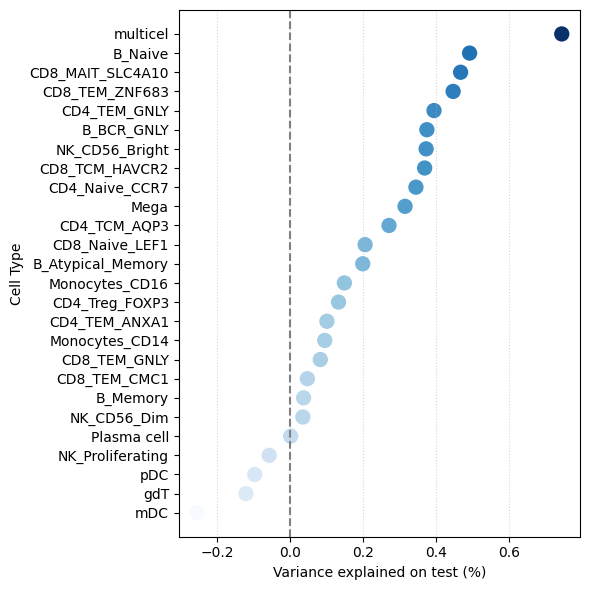

In [40]:
data = pd.concat([adata.obs[['sampleName','primary_type','secondary_type','age']].reset_index(drop=True),
                  pd.DataFrame(adata.obsm['U_mrvi']).reset_index(drop=True)], axis=1)
data = data.drop(columns='primary_type').groupby(['sampleName','secondary_type','age']).mean().reset_index()
data = data.dropna()
data.sampleName = data.sampleName.astype('str')
data.secondary_type = data.secondary_type.astype('str')
data.age = data.age.astype('float')

report = evaluate_cell_types(data, train_model)


sample_level_df = build_sample_level_dataset(cell_embeddings)
multicel = train_model(sample_level_df)
new_row = pd.DataFrame([['multicel', multicel]], columns=report.columns)
report = pd.concat([report, new_row], ignore_index=True)

draw_results(report)

# Z embedings

/tmp/ipykernel_1830255/2711258425.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = data.drop(columns='primary_type').groupby(['sampleName','secondary_type','age']).mean().reset_index()


Evaluating: B_Atypical_Memory
test_score: -0.05152551159679852
Evaluating: B_BCR_GNLY
test_score: 0.23301637420068655
Evaluating: B_Memory
test_score: -0.1344349721265734
Evaluating: B_Naive
test_score: 0.171958222453099
Evaluating: CD4_Naive_CCR7
test_score: -0.014895246740880053
Evaluating: CD4_TCM_AQP3
test_score: -0.08612444109400608
Evaluating: CD4_TEM_ANXA1
test_score: 0.3377442093394095
Evaluating: CD4_TEM_GNLY
test_score: 0.2370106009442028
Evaluating: CD4_Treg_FOXP3
test_score: 0.11774818574527113
Evaluating: CD8_MAIT_SLC4A10
test_score: 0.0780214222749448
Evaluating: CD8_Naive_LEF1
test_score: 0.10229686497230228
Evaluating: CD8_TCM_HAVCR2
test_score: 0.3424667806925499
Evaluating: CD8_TEM_CMC1
test_score: 0.0445836185186026
Evaluating: CD8_TEM_GNLY
test_score: -0.04684093445484838
Evaluating: CD8_TEM_ZNF683
test_score: 0.5473347424797017
Evaluating: Mega
test_score: 0.15721108480135426
Evaluating: Monocytes_CD14
test_score: 0.18833231745527956
Evaluating: Monocytes_CD16
test

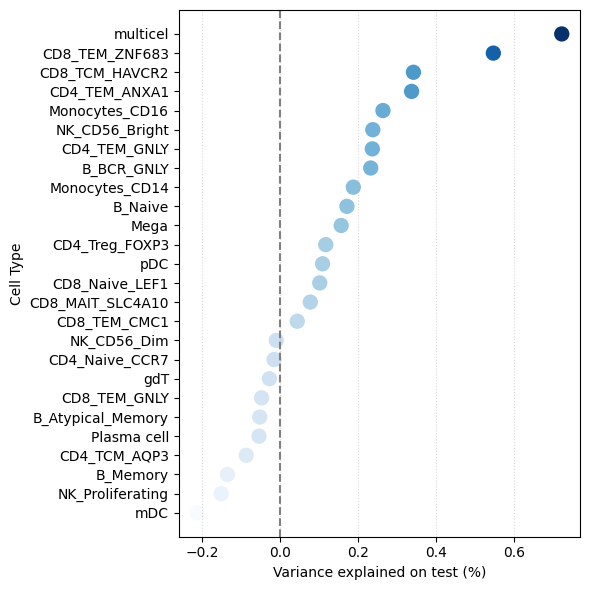

In [41]:
data = pd.concat([adata.obs[['sampleName','primary_type','secondary_type','age']].reset_index(drop=True),
                  pd.DataFrame(adata.obsm['Z_mrvi']).reset_index(drop=True)], axis=1)
data = data.drop(columns='primary_type').groupby(['sampleName','secondary_type','age']).mean().reset_index()
data = data.dropna()
data.sampleName = data.sampleName.astype('str')
data.secondary_type = data.secondary_type.astype('str')
data.age = data.age.astype('float')

report = evaluate_cell_types(data, train_model)


sample_level_df = build_sample_level_dataset(cell_embeddings)
multicel = train_model(sample_level_df)
new_row = pd.DataFrame([['multicel', multicel]], columns=report.columns)
report = pd.concat([report, new_row], ignore_index=True)

draw_results(report)